In [122]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [123]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [124]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\\python\\ML\\pothole_detection_CNN\\Data400',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1200 files belonging to 3 classes.


In [125]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [126]:
len(dataset)

38

In [127]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[1 0 1 2 2 1 1 1 2 0 1 1 2 0 1 0 0 2 1 0 2 2 2 1 0 0 0 2 2 1 1 2]


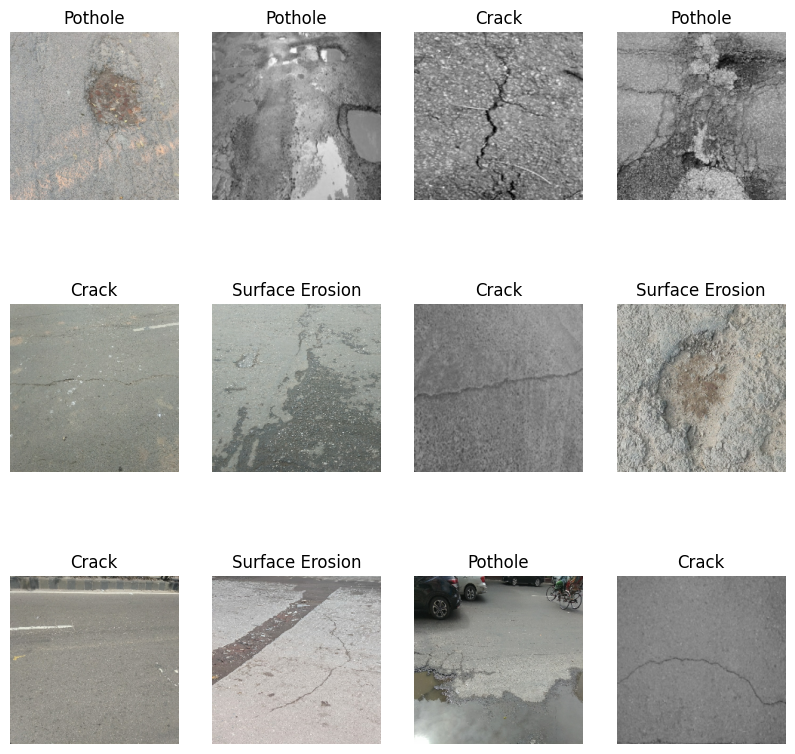

In [128]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [129]:
total_size = len(dataset)

In [130]:
# train_size = 0.8
# len(dataset)*train_size
# train_data = dataset.take(30)
# len(train_data)
# test_data = dataset.skip(30)
# len(test_data)
# validation_size = 0.1
# len(dataset)*validation_size
# validation_data = test_data.take(4)
# len(validation_data)
# test_data = test_data.skip(4)
# len(test_data)

In [ ]:

def partition_data(dataset, train_size=0.8, validation_size=0.1, test_size=0.1):
    total_size = len(dataset)
    print(total_size)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * validation_size)
    test_size = int(total_size * test_size)
    train_data = dataset.take(train_size)
    remaining_data = dataset.skip(train_size)
    
    validation_data = remaining_data.take(test_size)
    test_data = remaining_data.skip(test_size)
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = partition_data(dataset)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


38
Training data size: 30
Validation data size: 3
Test data size: 5


In [132]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [133]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [134]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:


def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model


In [136]:
model = build_mobilenet_model()

In [137]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_10 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [138]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [139]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 797ms/step - accuracy: 0.6343 - loss: 0.9215 - val_accuracy: 0.8021 - val_loss: 0.4345
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 966ms/step - accuracy: 0.8158 - loss: 0.4621 - val_accuracy: 0.8021 - val_loss: 0.3555
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 972ms/step - accuracy: 0.8238 - loss: 0.4376 - val_accuracy: 0.8542 - val_loss: 0.3698
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 988ms/step - accuracy: 0.8441 - loss: 0.3744 - val_accuracy: 0.8646 - val_loss: 0.3077
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 898ms/step - accuracy: 0.8531 - loss: 0.3561 - val_accuracy: 0.8958 - val_loss: 0.2847
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 587ms/step - accuracy: 0.8558 - loss: 0.3674 - val_accuracy: 0.8750 - val_loss: 0.2915
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 591ms/step - accuracy: 0.8652 - loss: 0.3520 - val_accuracy: 0.8958 - val_loss: 0.2686
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step - accuracy: 0.8855 - loss: 0.2980 - val_accu

In [140]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - accuracy: 0.8847 - loss: 0.2642


[0.34627968072891235, 0.8333333134651184]

In [141]:
model.save("Trained ModelsV2/MOBILENET.h5")
model.save("Trained ModelsV2/MOBILENET.keras")

In [142]:
# model = tf.keras.models.load_model("E:\python\ML\pothole_detection_CNN\Model\Trained ModelsV2\MOBILENETd64.keras")


In [ ]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 30}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.737500011920929,
 0.831250011920929,
 0.8510416746139526,
 0.8500000238418579,
 0.859375,
 0.8635416626930237,
 0.875,
 0.8708333373069763,
 0.8812500238418579,
 0.8885416388511658,
 0.890625,
 0.893750011920929,
 0.8854166865348816,
 0.890625,
 0.8843749761581421,
 0.8916666507720947,
 0.8979166746139526,
 0.90625,
 0.8958333134651184,
 0.9010416865348816,
 0.893750011920929,
 0.9114583134651184,
 0.903124988079071,
 0.9166666865348816,
 0.9135416746139526,
 0.9135416746139526,
 0.9270833134651184,
 0.9083333611488342,
 0.8979166746139526,
 0.8999999761581421,
 0.909375011920929,
 0.9229166507720947,
 0.90625,
 0.9125000238418579,
 0.9104166626930237,
 0.903124988079071,
 0.9270833134651184,
 0.9208333492279053,
 0.9333333373069763,
 0.9291666746139526,
 0.9260416626930237,
 0.9333333373069763,
 0.9291666746139526,
 0.9208333492279053,
 0.9125000238418579,
 0.921875,
 0.9260416626930237,
 0.9291666746139526,
 0.9322916865348816,
 0.918749988079071]

In [ ]:
y_true = []
y_pred = []
for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
F1 Score (macro): 0.8249838944834368
F1 Score (weighted): 0.8344935662699623

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.93      0.91      0.92        57
        Pothole       0.83      0.78      0.80        45
Surface Erosion       0.72      0.79      0.75        42

       accuracy                           0.83       144
      macro avg       0.83      0.83      0.82       144
   weighted avg       0.84      0.83      0.83       144



In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

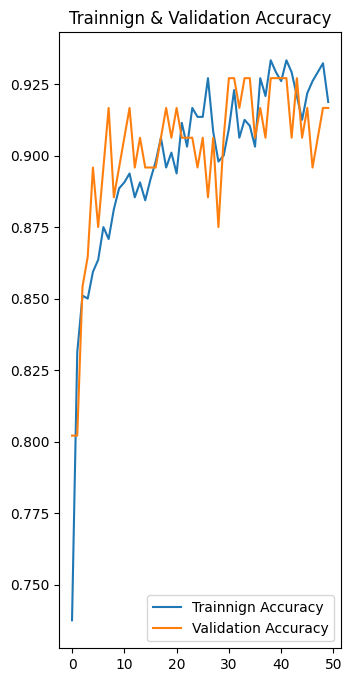

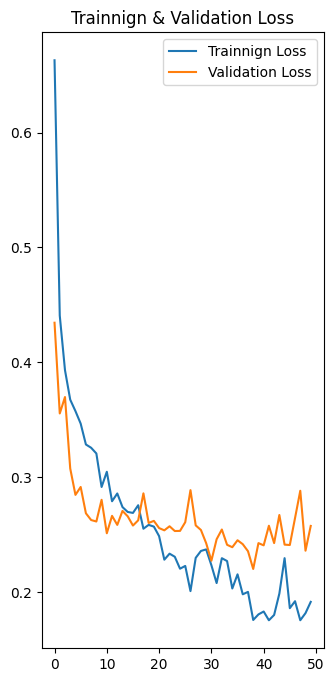

In [ ]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")
plt.show()

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [ ]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 429ms/step - accuracy: 0.7795 - loss: 0.4384


[0.34627971053123474, 0.8333333134651184]

First image to predict
First image actual label:  Pothole
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicted Label:  Surface Erosion


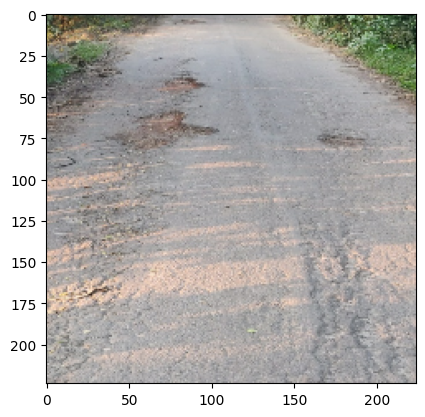

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->77.0 Light:-> Normal lighting
Confidence:->99.86000061035156 Light:-> Normal lighting
Confidence:->54.599998474121094 Light:-> Normal lighting
Confidence:->100.0 Light:-> Normal lighting
Confidence:->98.13999938964844 Light:-> Normal lighting
Confidence:->99.41999816894531 Light:-> Normal lighting
Confidence:->99.55999755859375 Light:-> Normal lighting
Confidence:->90.97000122070312 Light:-> Normal lighting
Confidence:->99.80000305175781 Light:-> Normal lighting


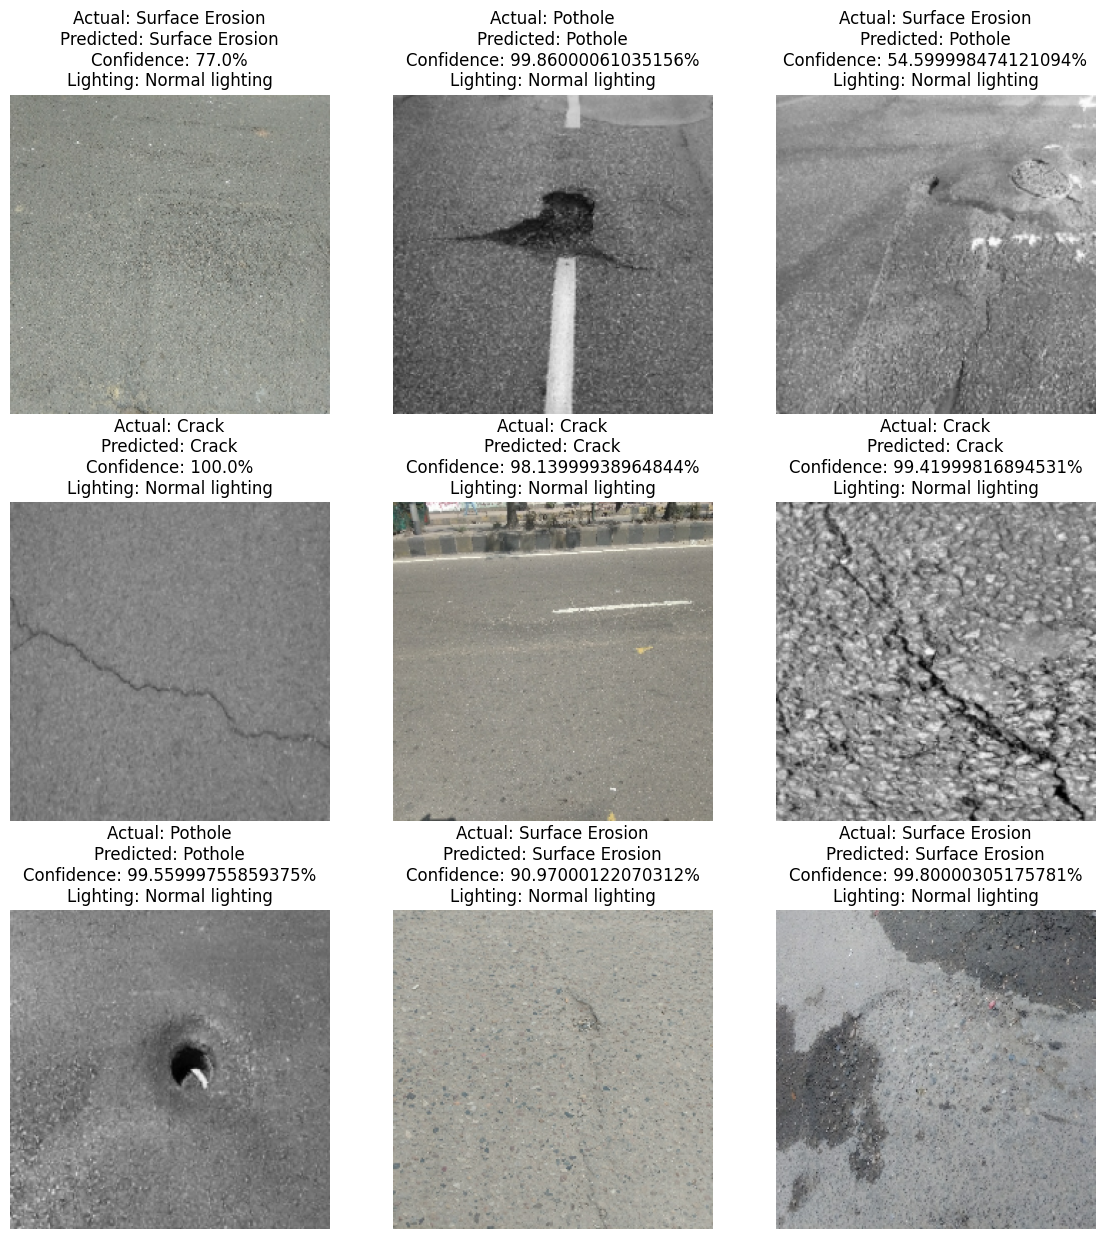

In [ ]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [ ]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")

Prediction: Surface Erosion, Confidence: 99.79000091552734


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


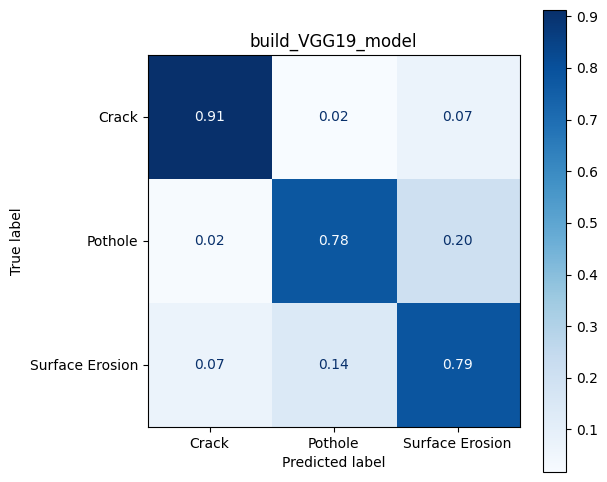

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("build_VGG19_model")
plt.savefig("confusion_matrix_mobilenet.png", dpi=300, bbox_inches='tight')
plt.show()
